## Important

### Make sure to run the `preprocess_rental_history.ipynb` notebook in the `notebooks/preprocessing/` directory to get the rental history data

### For the aggregates on scraped properties from Domain and the preprocessed Domain properties, run the `preprocess_scraped_properties.ipynb` notebook in the `notebooks/preprocessing/` directory

### Also download the `VIC Localities Shape File` from the [Google Drive](https://drive.google.com/drive/folders/1JzqWIVPAHOvMeD0X1u3RefYBSj1PehZ0?usp=sharing) and save that in the `data/map/` directory.

---

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
from folium import Choropleth

#### Load the rentals data

In [2]:
# Rental History Data
one_bed_flat = pd.read_csv('../../data/curated/rental_history/one_bed_flat.csv')
two_bed_flat = pd.read_csv('../../data/curated/rental_history/two_bed_flat.csv')
three_bed_flat = pd.read_csv('../../data/curated/rental_history/three_bed_flat.csv')
two_bed_house = pd.read_csv('../../data/curated/rental_history/two_bed_house.csv')
three_bed_house = pd.read_csv('../../data/curated/rental_history/three_bed_house.csv')
four_bed_house = pd.read_csv('../../data/curated/rental_history/four_bed_house.csv')
all_properties = pd.read_csv('../../data/curated/rental_history/all_properties.csv')

# Domain Rental Data
domain_one_bed_flat = pd.read_csv('../../data/curated/domain/domain_one_bed_flat_rent.csv')
domain_two_bed_flat = pd.read_csv('../../data/curated/domain/domain_two_bed_flat_rent.csv')
domain_three_bed_flat = pd.read_csv('../../data/curated/domain/domain_three_bed_flat_rent.csv')
domain_two_bed_house = pd.read_csv('../../data/curated/domain/domain_two_bed_house_rent.csv')
domain_three_bed_house = pd.read_csv('../../data/curated/domain/domain_three_bed_house_rent.csv')
domain_four_bed_house = pd.read_csv('../../data/curated/domain/domain_four_bed_house_rent.csv')
domain_all_properties = pd.read_csv('../../data/curated/domain/domain_all_properties_rent.csv')

#### Load the victorian suburbs shape file

In [3]:
# Load Victoria suburbs shapefile for filtering
vic_suburbs_gdf = gpd.read_file('../../data/map/VIC Localities Shape File/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)
vic_suburbs_gdf['suburb'] = vic_suburbs_gdf['GAZLOC'].str.lower()

In [4]:
# Sort by the average rent and take the top 10 suburbs
top_10_suburbs = one_bed_flat.sort_values(by='mar_2024_median', ascending=False).head(10)

# Melt the data for these top suburbs to visualize over time
top_10_melted = top_10_suburbs.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')


In [5]:
rental_files = {'one_bed_flat': one_bed_flat, 'two_bed_flat': two_bed_flat, 'three_bed_flat': three_bed_flat, 'two_bed_house': two_bed_house,
                'three_bed_house': three_bed_house, 'four_bed_house': four_bed_house, 'all_properties': all_properties}
domain_files = {'one_bed_flat': domain_one_bed_flat, 'two_bed_flat': domain_two_bed_flat, 'three_bed_flat': domain_three_bed_flat, 'two_bed_house': domain_two_bed_house,
                'three_bed_house': domain_three_bed_house, 'four_bed_house': domain_four_bed_house, 'all_properties': domain_all_properties}

#### Map the top 10 suburbs for each type of property

In [25]:
property_colors = {
    'one_bed_flat': '#F82B35',  
    'two_bed_flat': '#F82B9C',  
    'three_bed_flat': '#ED2BF8',  
    'two_bed_house': '#872BF8',  
    'three_bed_house': '#2B36F8',  
    'four_bed_house': '#2B9CF8'  
}

# Adjust the styling of the map
highlighted_style_template = {
    'fillOpacity': 0.6, 
    'color': 'black', 
    'weight': 1.0 
}

# folium map centered at Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

# Iterate through each property type and add the corresponding colors based on the type of property
for property_type, color in property_colors.items():
    highlighted_style = highlighted_style_template.copy()
    highlighted_style['fillColor'] = color

    merged_gdf = vic_suburbs_gdf.merge(domain_files[property_type], on='suburb', how='inner')
    merged_gdf = merged_gdf.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')
    top_10_suburbs = merged_gdf.sort_values(by='num_properties', ascending=False).head(10)
    
    # Add GeoJson to the map with custom color and tooltip
    for i, row in top_10_suburbs.iterrows():
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': 'black',  
                'fillOpacity': 0.6,  
                'weight': 1.0  
            },
            tooltip=folium.Tooltip(f"Suburb: {row['suburb'].capitalize()}<br>Median Rent: ${row['median_rent']}<br>Properties: {row['num_properties']}")
        ).add_to(m)

# Legend
legend_html = '''
<div style="position: fixed;
     bottom: 30px; left: 30px; width: 200px; height: 280px;
     background-color: white; border:2px solid grey; z-index:9999; font-size:16px;
     ">&nbsp; <b>Property Type Legend</b><br>
     &nbsp; <i style="color:#F82B35; font-size:20px;">■</i>&nbsp; One-bed Flat<br>
     &nbsp; <i style="color:#F82B9C; font-size:20px;">■</i>&nbsp; Two-bed Flat<br>
     &nbsp; <i style="color:#ED2BF8; font-size:20px;">■</i>&nbsp; Three-bed Flat<br>
     &nbsp; <i style="color:#872BF8; font-size:20px;">■</i>&nbsp; Two-bed House<br>
     &nbsp; <i style="color:#2B36F8; font-size:20px;">■</i>&nbsp; Three-bed House<br>
     &nbsp; <i style="color:#2B9CF8; font-size:20px;">■</i>&nbsp; Four-bed House<br>
</div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map 
m.save("../../plots/rental_properties_visualisations/domain_top_10_property_types_map.html")


#### Load the properties data (scraped from domain)

In [9]:
properties = pd.read_csv("../../data/raw/properties.csv")

In [10]:
properties

,suburb,postcode,property_type,weekly_rent,bond,num_bed,num_bath,num_parkings,furnished,pets_allowed,coordinates
0,melbourne,3000,Apartment,530.0,2303.0,1,1,1,False,False,"-37.8102191,144.966267"
1,melbourne,3000,Apartment,500.0,2173.0,1,1,0,False,False,"-37.810779,144.9685513"
2,melbourne,3000,Apartment,470.0,2042.0,1,1,0,False,False,"-37.81441450000001,144.9539107"
3,melbourne,3000,Apartment,400.0,1738.0,1,1,0,True,False,"-37.8175167,144.9664983"
4,melbourne,3000,Apartment,520.0,2260.0,2,1,0,True,False,"-37.8099061,144.9711071"
...,...,...,...,...,...,...,...,...,...,...,...
13615,sunset strip,3922,House,800.0,3476.0,4,2,0,True,False,"-38.4959115,145.2640573"
13616,rosebud,3939,House,700.0,3042.0,4,3,2,False,False,"-38.3579258,144.9109711"
13617,cranbourne,3977,House,510.0,2216.0,3,1,6,False,False,"-38.0920656,145.2781526"
13618,cranbourne,3977,House,240.0,960.0,1,1,0,False,False,"-38.1019484,145.2876772"


#### Look at the distribution of rent for furnished & unfurnished properties

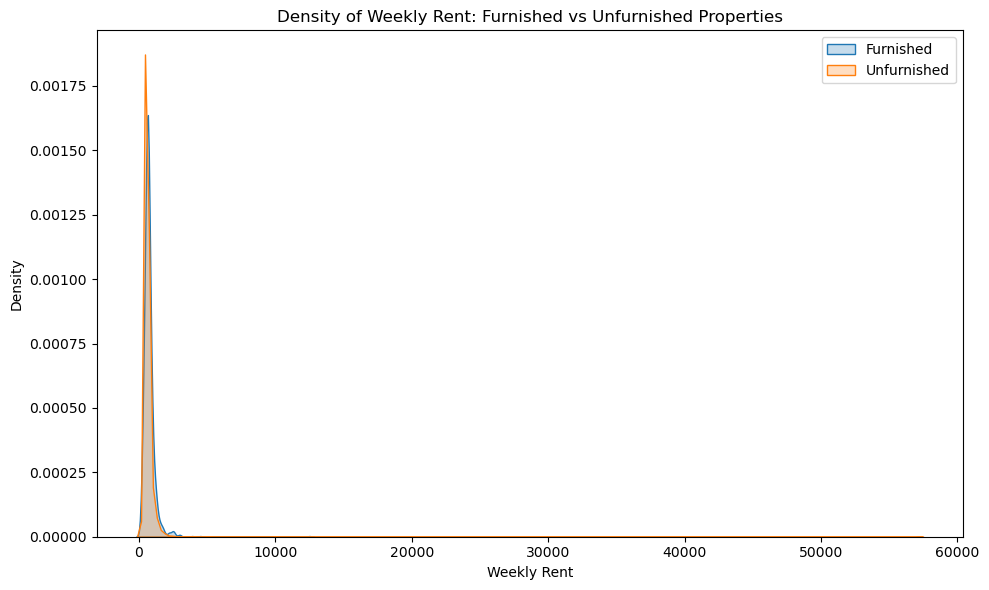

In [11]:
# plt.figure(figsize=(10, 6))

# # Plot the KDE for both furnished and unfurnished properties
# sns.kdeplot(data=properties[properties['furnished'] == True], x='weekly_rent', label='Furnished', fill=True)
# sns.kdeplot(data=properties[properties['furnished'] == False], x='weekly_rent', label='Unfurnished', fill=True)

# # Add labels and title
# plt.title('Density of Weekly Rent: Furnished vs Unfurnished Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()


#### Map the same graph but after removing outliers

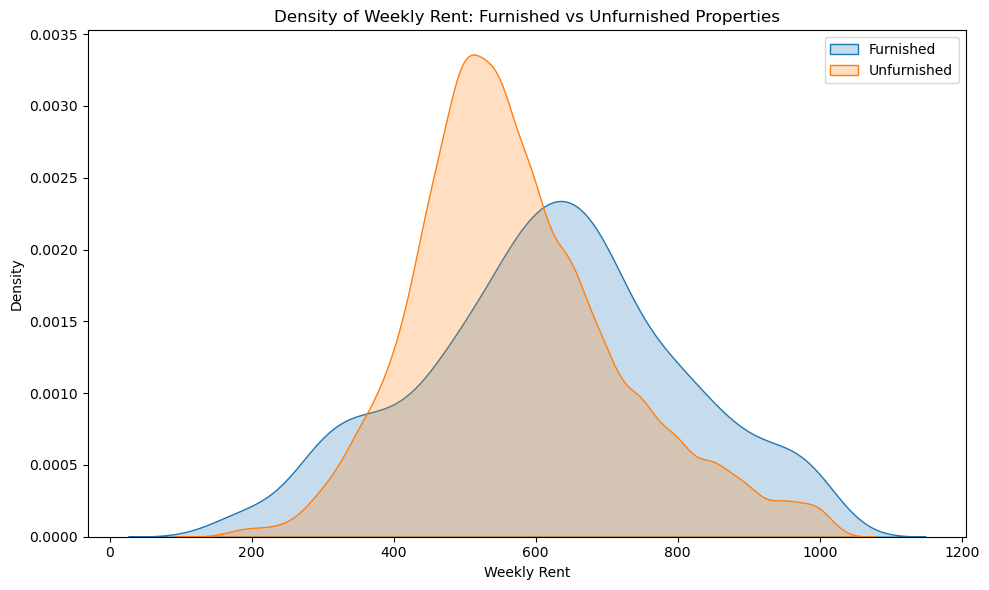

In [26]:
Q1 = properties['weekly_rent'].quantile(0.25)
Q3 = properties['weekly_rent'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the data
filtered_properties = properties[(properties['weekly_rent'] >= lower_bound) & (properties['weekly_rent'] <= upper_bound)]

# Now plot using the data with outliers removed
plt.figure(figsize=(10, 6))

# Plot the KDE for both furnished and unfurnished properties
sns.kdeplot(data=filtered_properties[filtered_properties['furnished'] == True], x='weekly_rent', label='Furnished', fill=True)
sns.kdeplot(data=filtered_properties[filtered_properties['furnished'] == False], x='weekly_rent', label='Unfurnished', fill=True)


plt.title('Density of Weekly Rent: Furnished vs Unfurnished Properties')
plt.xlabel('Weekly Rent')
plt.ylabel('Density')

plt.legend()
plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/un-furnished_density.png")
plt.show()


#### Check the distribution of weekly rent for properties where pets are allowed & where pets aren't allowed

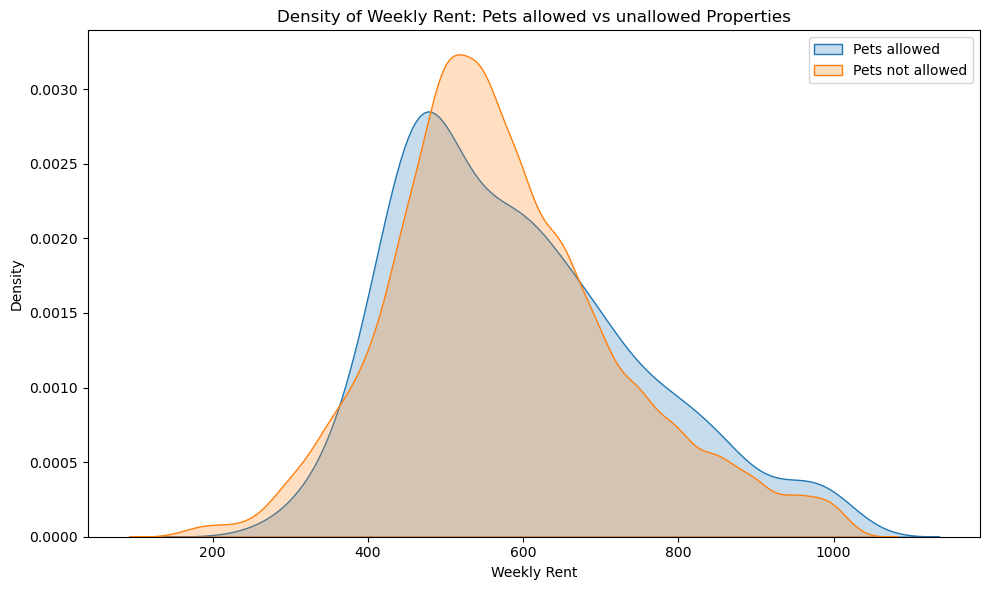

In [15]:
# # Now plot using the cleaned dataset
# plt.figure(figsize=(10, 6))

# # Plot the KDE for both furnished and unfurnished properties
# sns.kdeplot(data=filtered_properties[filtered_properties['pets_allowed'] == True], x='weekly_rent', label='Pets allowed', fill=True)
# sns.kdeplot(data=filtered_properties[filtered_properties['pets_allowed'] == False], x='weekly_rent', label='Pets not allowed', fill=True)

# # Add labels and title
# plt.title('Density of Weekly Rent: Pets allowed vs unallowed Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()

#### Remove outliers from the properties for both Apartments & Houses

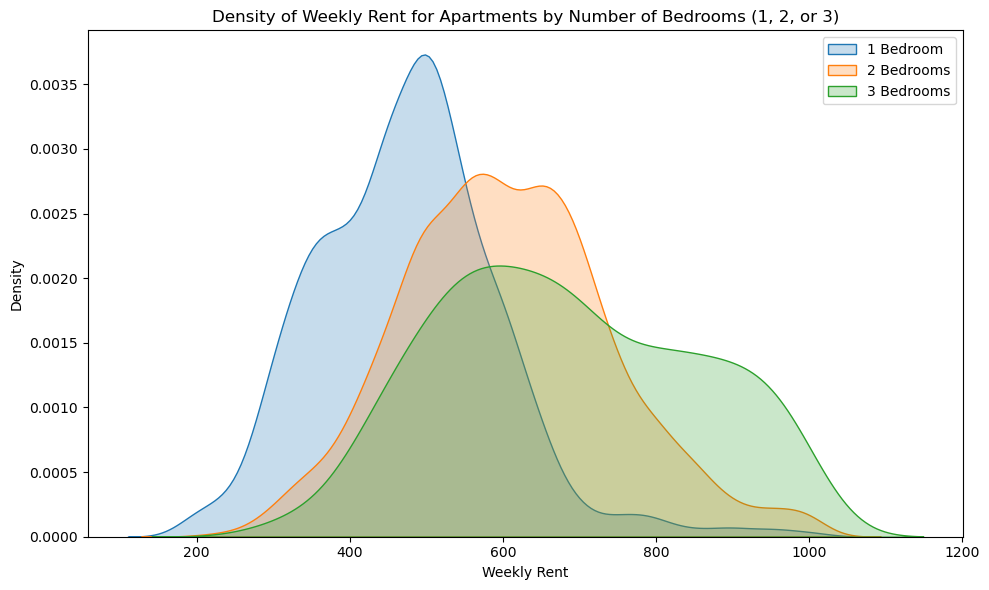

In [27]:
# Filter the data for properties where property_type is "Apartment" and num_bed is 1, 2, or 3
apartment_properties = properties[(properties['property_type'] == 'Apartment') & (properties['num_bed'].isin([1, 2, 3]))]

Q1 = properties['weekly_rent'].quantile(0.25)
Q3 = properties['weekly_rent'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the data
apartment_properties = apartment_properties[(apartment_properties['weekly_rent'] >= lower_bound) & (apartment_properties['weekly_rent'] <= upper_bound)]


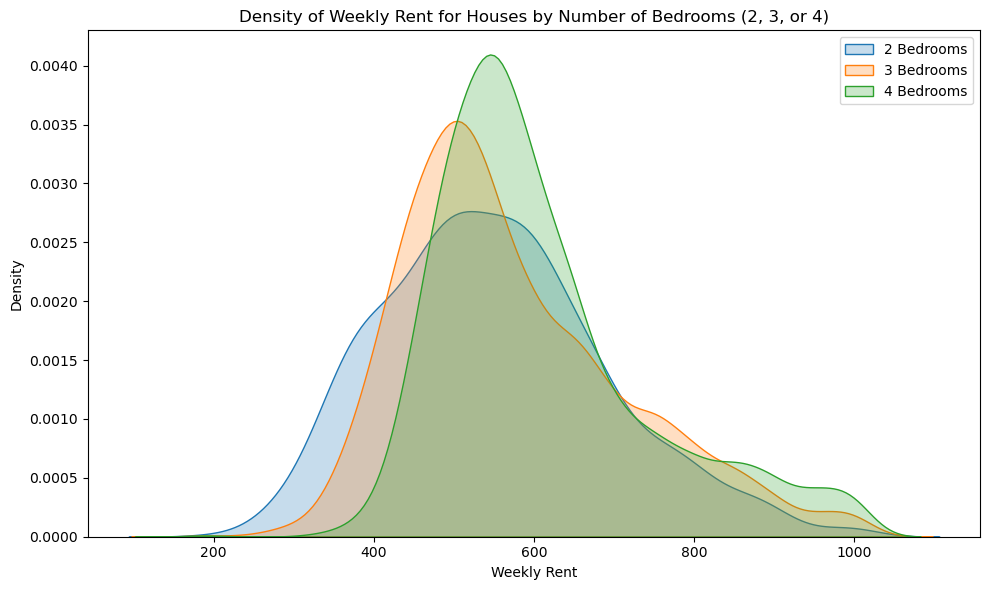

In [28]:
# Filter the data for properties where property_type is "House" and num_bed is 2,3,4
house_properties = properties[(properties['property_type'] == 'House') & (properties['num_bed'].isin([2, 3, 4]))]

Q1 = properties['weekly_rent'].quantile(0.25)
Q3 = properties['weekly_rent'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the data
house_properties = house_properties[(house_properties['weekly_rent'] >= lower_bound) & (house_properties['weekly_rent'] <= upper_bound)]

#### Plot the distribution for weekly rent based on the number of bedrooms for both apartments & houses

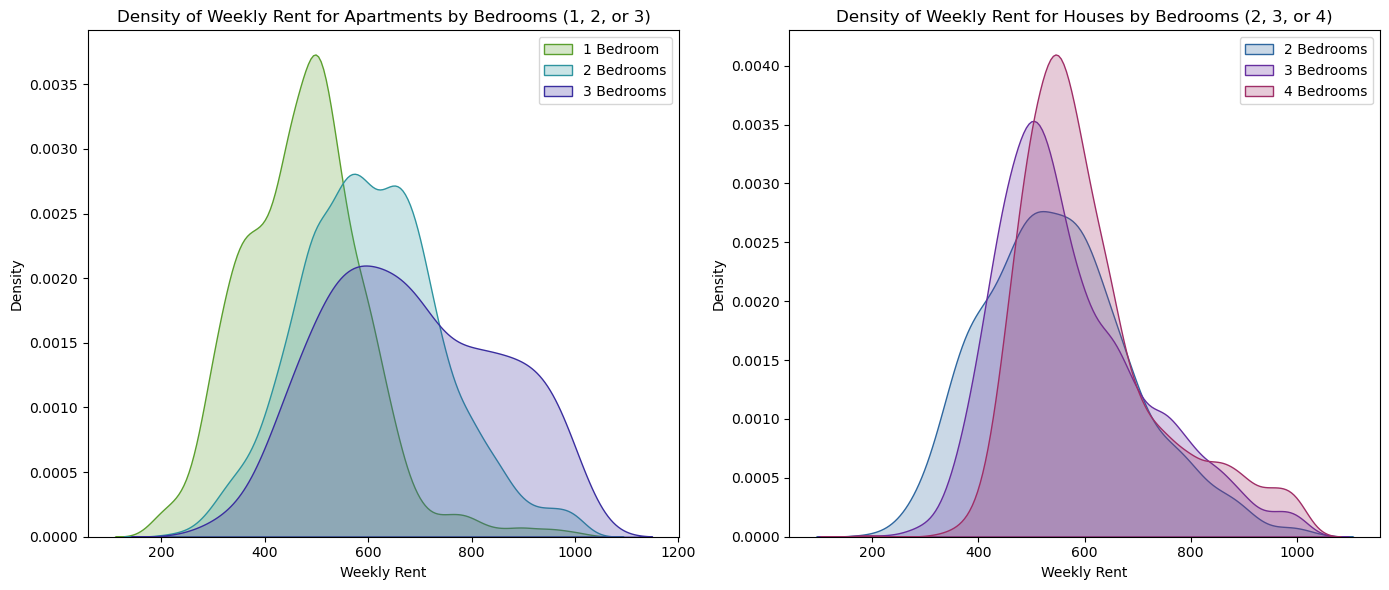

In [32]:
apartment_colors = ['#5B9F2E', '#2E949F', '#3A2E9F']  
house_colors = ['#2E679F', '#662E9F', '#9F2E67'] 

# Create subplots for apartment and house KDE plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 1], x='weekly_rent', label='1 Bedroom', fill=True, ax=axes[0], color=apartment_colors[0])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True, ax=axes[0], color=apartment_colors[1])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True, ax=axes[0], color=apartment_colors[2])
axes[0].set_title('Density of Weekly Rent for Apartments by Bedrooms (1, 2, or 3)')
axes[0].set_xlabel('Weekly Rent')
axes[0].set_ylabel('Density')
axes[0].legend()

# Second subplot: Houses
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True, ax=axes[1], color=house_colors[0])
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True, ax=axes[1], color=house_colors[1])
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 4], x='weekly_rent', label='4 Bedrooms', fill=True, ax=axes[1], color=house_colors[2])
axes[1].set_title('Density of Weekly Rent for Houses by Bedrooms (2, 3, or 4)')
axes[1].set_xlabel('Weekly Rent')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()

plt.savefig("../../plots/rental_properties_visualisations/weekly_rent_distribution.png")
plt.show()


#### Plot the trends in the current most expensive and least expensive suburbs for the two bed flats

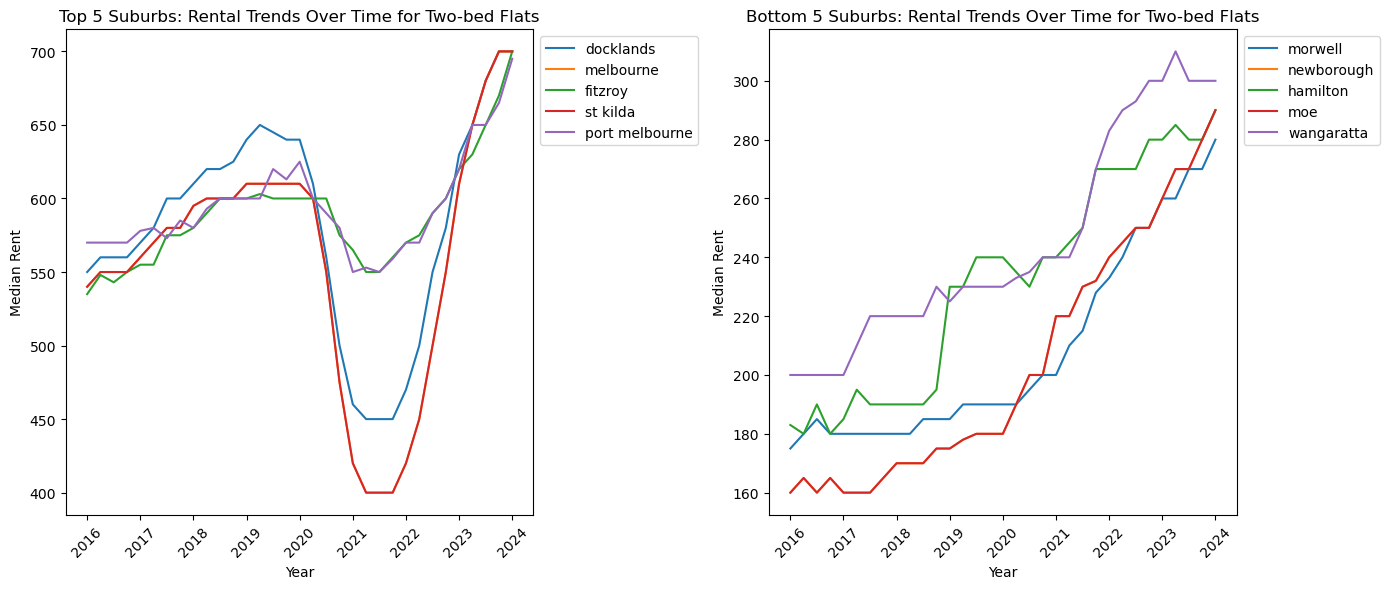

In [65]:
two_bed_flat = two_bed_flat[two_bed_flat['suburb'].str.lower() != 'group total']

# Identify top 5 and bottom 5 suburbs based on the most recent median rent
top_5_expensive = two_bed_flat.sort_values(by='mar_2024_median', ascending=False).head(5)
bottom_5_cheap = two_bed_flat.sort_values(by='mar_2024_median', ascending=True).head(5)

# Melt the data for plotting trends over time 
top_5_melted = top_5_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_5_melted = bottom_5_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

# Create a figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Plot for Top 5 Most Expensive Suburbs
sns.lineplot(data=top_5_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[0])
axes[0].set_title('Top 5 Suburbs: Rental Trends Over Time for Two-bed Flats')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Plot for Bottom 5 Least Expensive Suburbs 
sns.lineplot(data=bottom_5_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[1])
axes[1].set_title('Bottom 5 Suburbs: Rental Trends Over Time for Two-bed Flats')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Extract the year from the quarter strings like 'mar_2016_median' for formatting the plot ticks
for ax in axes:
    # Get the current x-tick labels and extract the year from each label
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] if '_' in label else label for label in xticks_labels] 

    # Update the x-tick labels with the extracted years
    ax.set_xticks(ax.get_xticks()[::4])  
    ax.set_xticklabels(years[::4])

plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/2bflat_comparison.png")
plt.show()

#### Plot the trends in the current most expensive and least expensive suburbs for the two bed houses

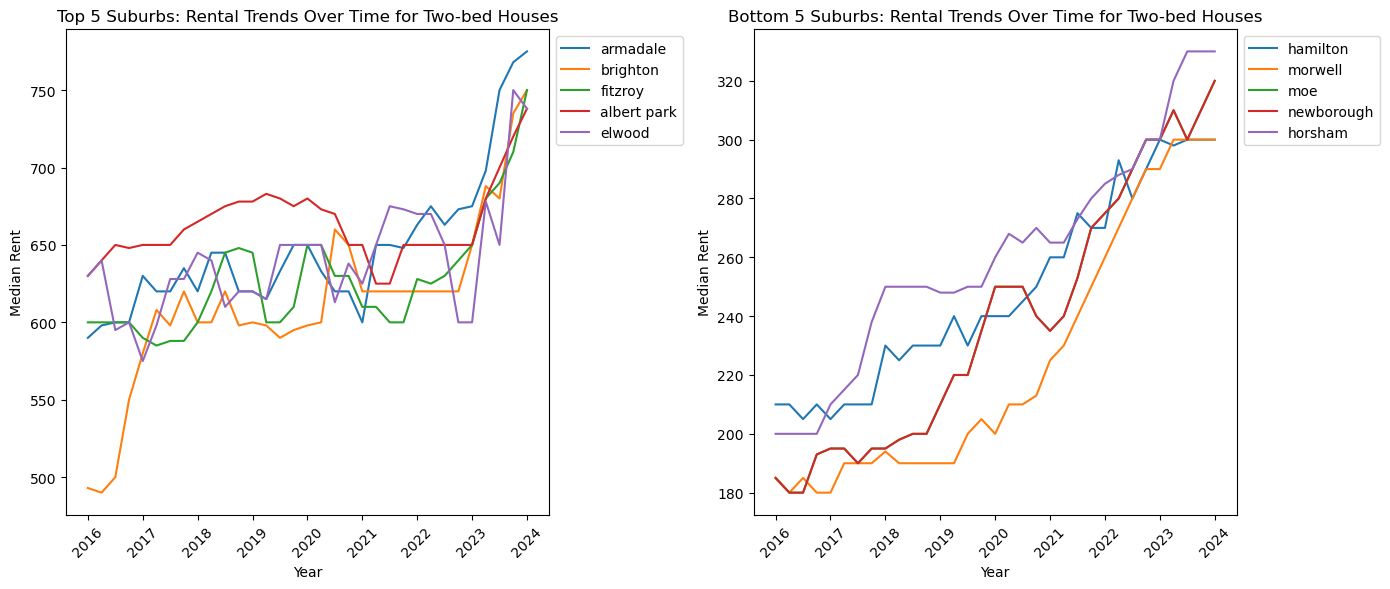

In [67]:
two_bed_house = two_bed_house[two_bed_house['suburb'].str.lower() != 'group total']

# Identify top 5 and bottom 5 suburbs based on the most recent median rent
top_5_expensive = two_bed_house.sort_values(by='mar_2024_median', ascending=False).head(5)
bottom_5_cheap = two_bed_house.sort_values(by='mar_2024_median', ascending=True).head(5)

# Melt the data for plotting trends over time
top_5_melted = top_5_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_5_melted = bottom_5_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

# Plot for Top 5 Most Expensive Suburbs (on the first subplot)
sns.lineplot(data=top_5_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[0])
axes[0].set_title('Top 5 Suburbs: Rental Trends Over Time for Two-bed Houses')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Plot for Bottom 5 Least Expensive Suburbs
sns.lineplot(data=bottom_5_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[1])
axes[1].set_title('Bottom 5 Suburbs: Rental Trends Over Time for Two-bed Houses')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  

# Extract the year from the quarter strings like 'mar_2016_median' for formatting the plot ticks
# Same as previous plot
for ax in axes:
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] if '_' in label else label for label in xticks_labels]

    ax.set_xticks(ax.get_xticks()[::4])  
    ax.set_xticklabels(years[::4]) 

plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/2bhouse_comparison.png")
plt.show()

#### Plot the trends in the current most expensive and least expensive suburbs for the two bed flats while offsetting the lines so that they don't overlap - JUST FOR VISUALIZATION PURPOSES

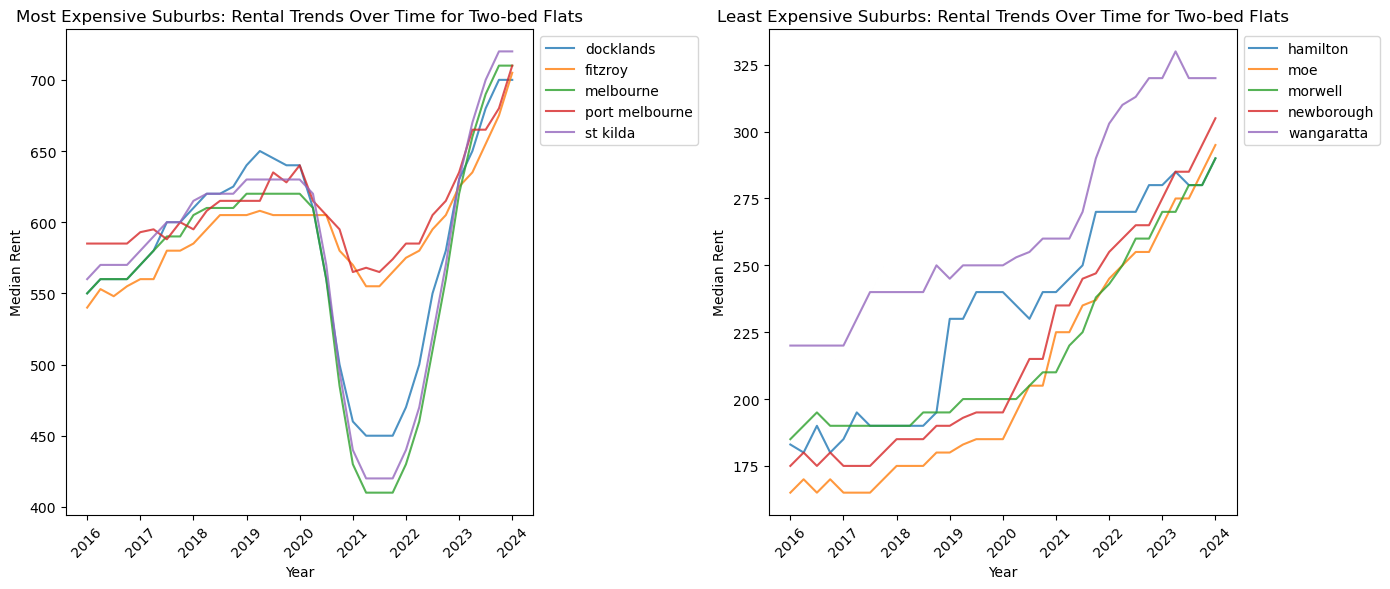

In [77]:
two_bed_flat = two_bed_flat[two_bed_flat['suburb'].str.lower() != 'group total']

# top 5 and bottom 5 suburbs based on the most recent median rent
top_5_expensive = two_bed_flat.sort_values(by='mar_2024_median', ascending=False).head(5)
bottom_5_cheap = two_bed_flat.sort_values(by='mar_2024_median', ascending=True).head(5)

# Melt the data for plotting trends over time
top_5_melted = top_5_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_5_melted = bottom_5_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

offset_factor = 5  # Offset each line by a small amount to reduce overlap

# Plot for Top 5 Most Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(top_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[0], alpha=0.8, linewidth=1.5)
axes[0].set_title('Most Expensive Suburbs: Rental Trends Over Time for Two-bed Flats')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot for Bottom 5 Least Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(bottom_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[1], alpha=0.8, linewidth=1.5)
axes[1].set_title('Least Expensive Suburbs: Rental Trends Over Time for Two-bed Flats')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# format x-ticks to show only the year
for ax in axes:
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] if '_' in label else label for label in xticks_labels]
    ax.set_xticks(ax.get_xticks()[::4]) 
    ax.set_xticklabels(years[::4])

plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/2bflat_comparison_offset.png")
plt.show()


#### Plot the trends in the current most expensive and least expensive suburbs for the two bed houses while offsetting the lines so that they don't overlap - JUST FOR VISUALIZATION PURPOSES

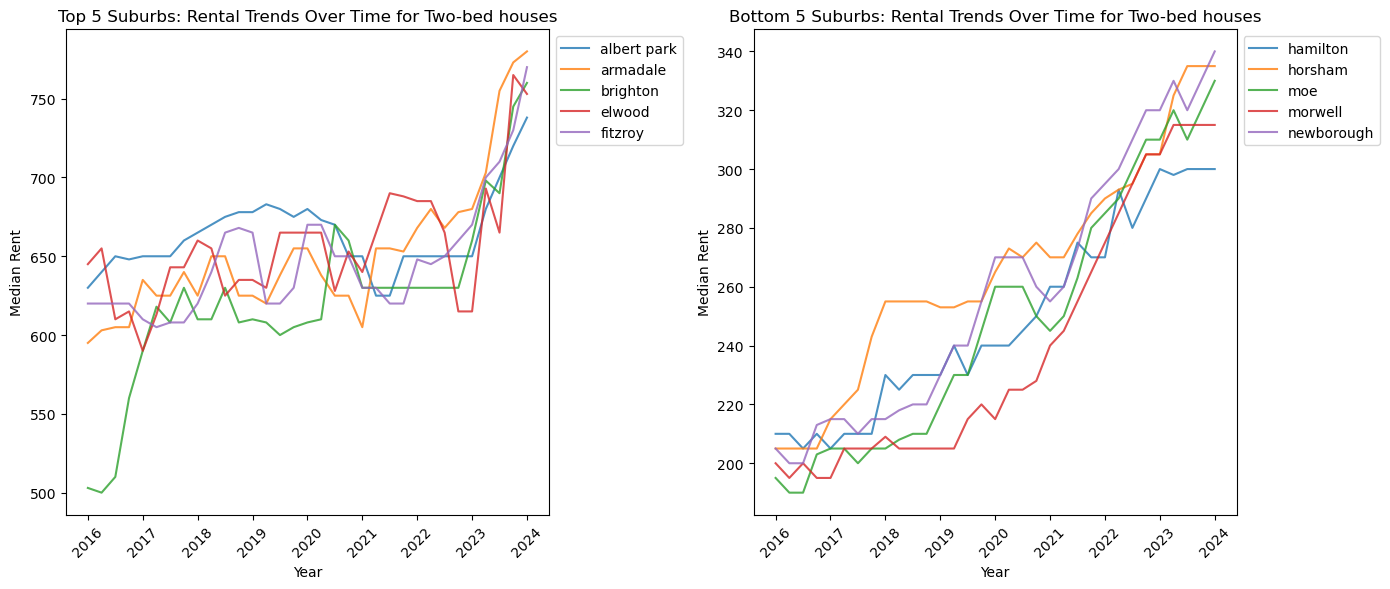

In [69]:
two_bed_house = two_bed_house[two_bed_house['suburb'].str.lower() != 'group total']

# top 5 and bottom 5 suburbs based on the most recent median rent
top_5_expensive = two_bed_house.sort_values(by='mar_2024_median', ascending=False).head(5)
bottom_5_cheap = two_bed_house.sort_values(by='mar_2024_median', ascending=True).head(5)

# Melt the data for plotting trends over time
top_5_melted = top_5_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_5_melted = bottom_5_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

offset_factor = 5  # Offset each line by a small amount to reduce overlap

# Plot for Top 5 Most Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(top_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[0], alpha=0.8, linewidth=1.5)
axes[0].set_title('Top 5 Suburbs: Rental Trends Over Time for Two-bed houses')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Plot for Bottom 5 Least Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(bottom_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[1], alpha=0.8, linewidth=1.5)
axes[1].set_title('Bottom 5 Suburbs: Rental Trends Over Time for Two-bed houses')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# format x-ticks to show only the year
for ax in axes:
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] if '_' in label else label for label in xticks_labels]
    ax.set_xticks(ax.get_xticks()[::4]) 
    ax.set_xticklabels(years[::4])

plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/2bhouse_comparison_offset.png")
plt.show()


#### Plot the distribution for weekly rent based on the number of bathrooms for both apartments & houses

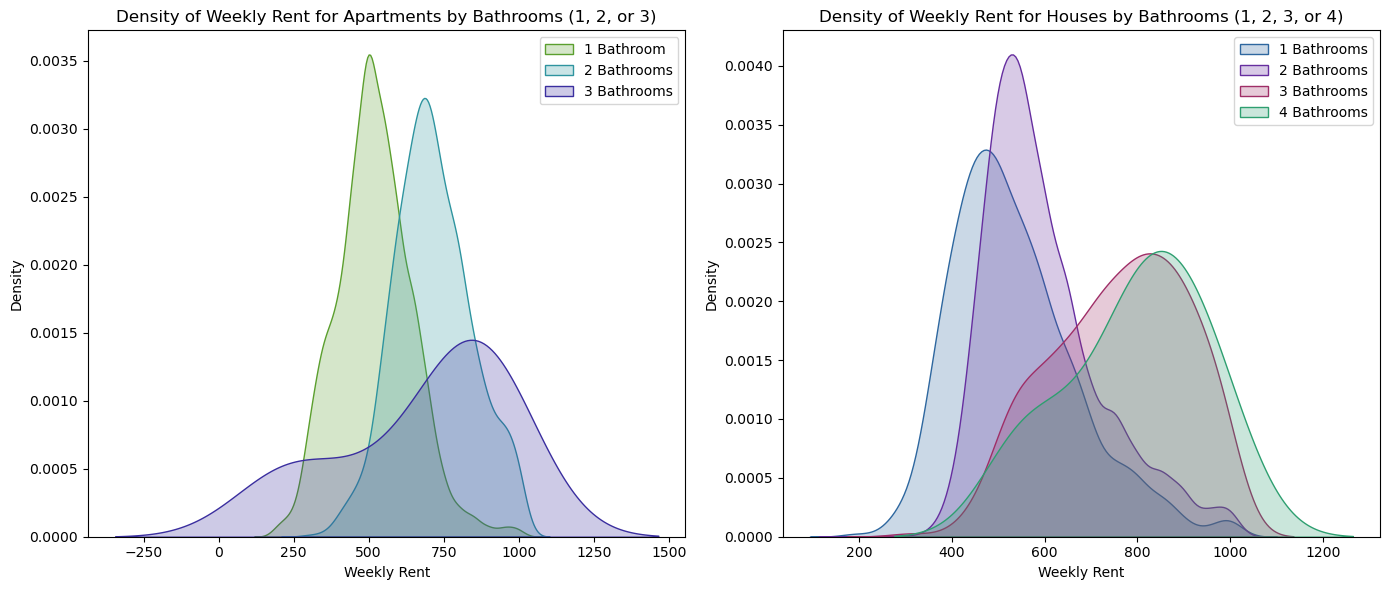

In [73]:
apartment_colors = ['#5B9F2E', '#2E949F', '#3A2E9F']  
house_colors = ['#2E679F', '#662E9F', '#9F2E67', '#2E9F70'] 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_bath'] == 1], x='weekly_rent', label='1 Bathroom', fill=True, ax=axes[0], color=apartment_colors[0])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bath'] == 2], x='weekly_rent', label='2 Bathrooms', fill=True, ax=axes[0], color=apartment_colors[1])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bath'] == 3], x='weekly_rent', label='3 Bathrooms', fill=True, ax=axes[0], color=apartment_colors[2])
axes[0].set_title('Density of Weekly Rent for Apartments by Bathrooms (1, 2, or 3)')
axes[0].set_xlabel('Weekly Rent')
axes[0].set_ylabel('Density')
axes[0].legend()

# Second subplot: Houses
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 1], x='weekly_rent', label='1 Bathrooms', fill=True, ax=axes[1], color=house_colors[0])
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 2], x='weekly_rent', label='2 Bathrooms', fill=True, ax=axes[1], color=house_colors[1])
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 3], x='weekly_rent', label='3 Bathrooms', fill=True, ax=axes[1], color=house_colors[2])
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 4], x='weekly_rent', label='4 Bathrooms', fill=True, ax=axes[1], color=house_colors[3])

axes[1].set_title('Density of Weekly Rent for Houses by Bathrooms (1, 2, 3, or 4)')
axes[1].set_xlabel('Weekly Rent')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()

plt.savefig("../../plots/rental_properties_visualisations/weekly_rent_distribution_bath.png")
plt.show()


#### Plot the distribution for weekly rent based on the number of parkings for both apartments & houses

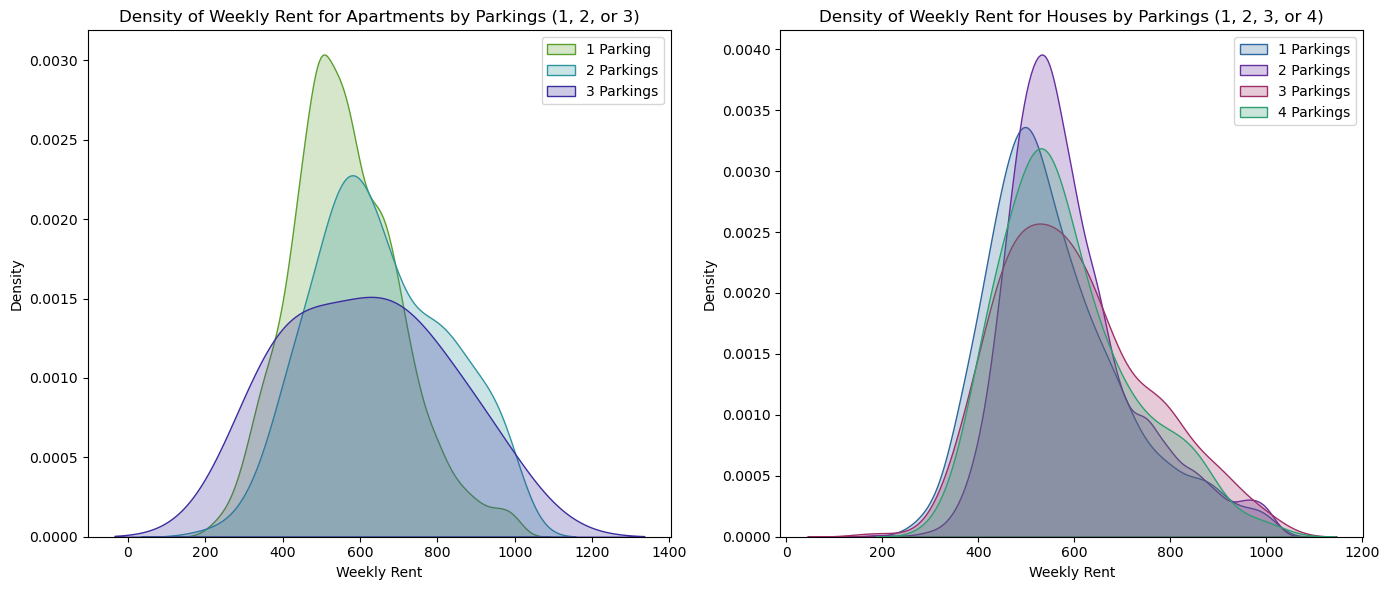

In [74]:
apartment_colors = ['#5B9F2E', '#2E949F', '#3A2E9F']  
house_colors = ['#2E679F', '#662E9F', '#9F2E67', '#2E9F70'] 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_parkings'] == 1], x='weekly_rent', label='1 Parking', fill=True, ax=axes[0], color=apartment_colors[0])
sns.kdeplot(data=apartment_properties[apartment_properties['num_parkings'] == 2], x='weekly_rent', label='2 Parkings', fill=True, ax=axes[0], color=apartment_colors[1])
sns.kdeplot(data=apartment_properties[apartment_properties['num_parkings'] == 3], x='weekly_rent', label='3 Parkings', fill=True, ax=axes[0], color=apartment_colors[2])
axes[0].set_title('Density of Weekly Rent for Apartments by Parkings (1, 2, or 3)')
axes[0].set_xlabel('Weekly Rent')
axes[0].set_ylabel('Density')
axes[0].legend()

# Second subplot: Houses
sns.kdeplot(data=house_properties[house_properties['num_parkings'] == 1], x='weekly_rent', label='1 Parkings', fill=True, ax=axes[1], color=house_colors[0])
sns.kdeplot(data=house_properties[house_properties['num_parkings'] == 2], x='weekly_rent', label='2 Parkings', fill=True, ax=axes[1], color=house_colors[1])
sns.kdeplot(data=house_properties[house_properties['num_parkings'] == 3], x='weekly_rent', label='3 Parkings', fill=True, ax=axes[1], color=house_colors[2])
sns.kdeplot(data=house_properties[house_properties['num_parkings'] == 4], x='weekly_rent', label='4 Parkings', fill=True, ax=axes[1], color=house_colors[3])

axes[1].set_title('Density of Weekly Rent for Houses by Parkings (1, 2, 3, or 4)')
axes[1].set_xlabel('Weekly Rent')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()

plt.savefig("../../plots/rental_properties_visualisations/weekly_rent_distribution_parking.png")
plt.show()


#### Plot the distribution for weekly rent based on the number of bedrooms & bathrooms for both apartments & houses

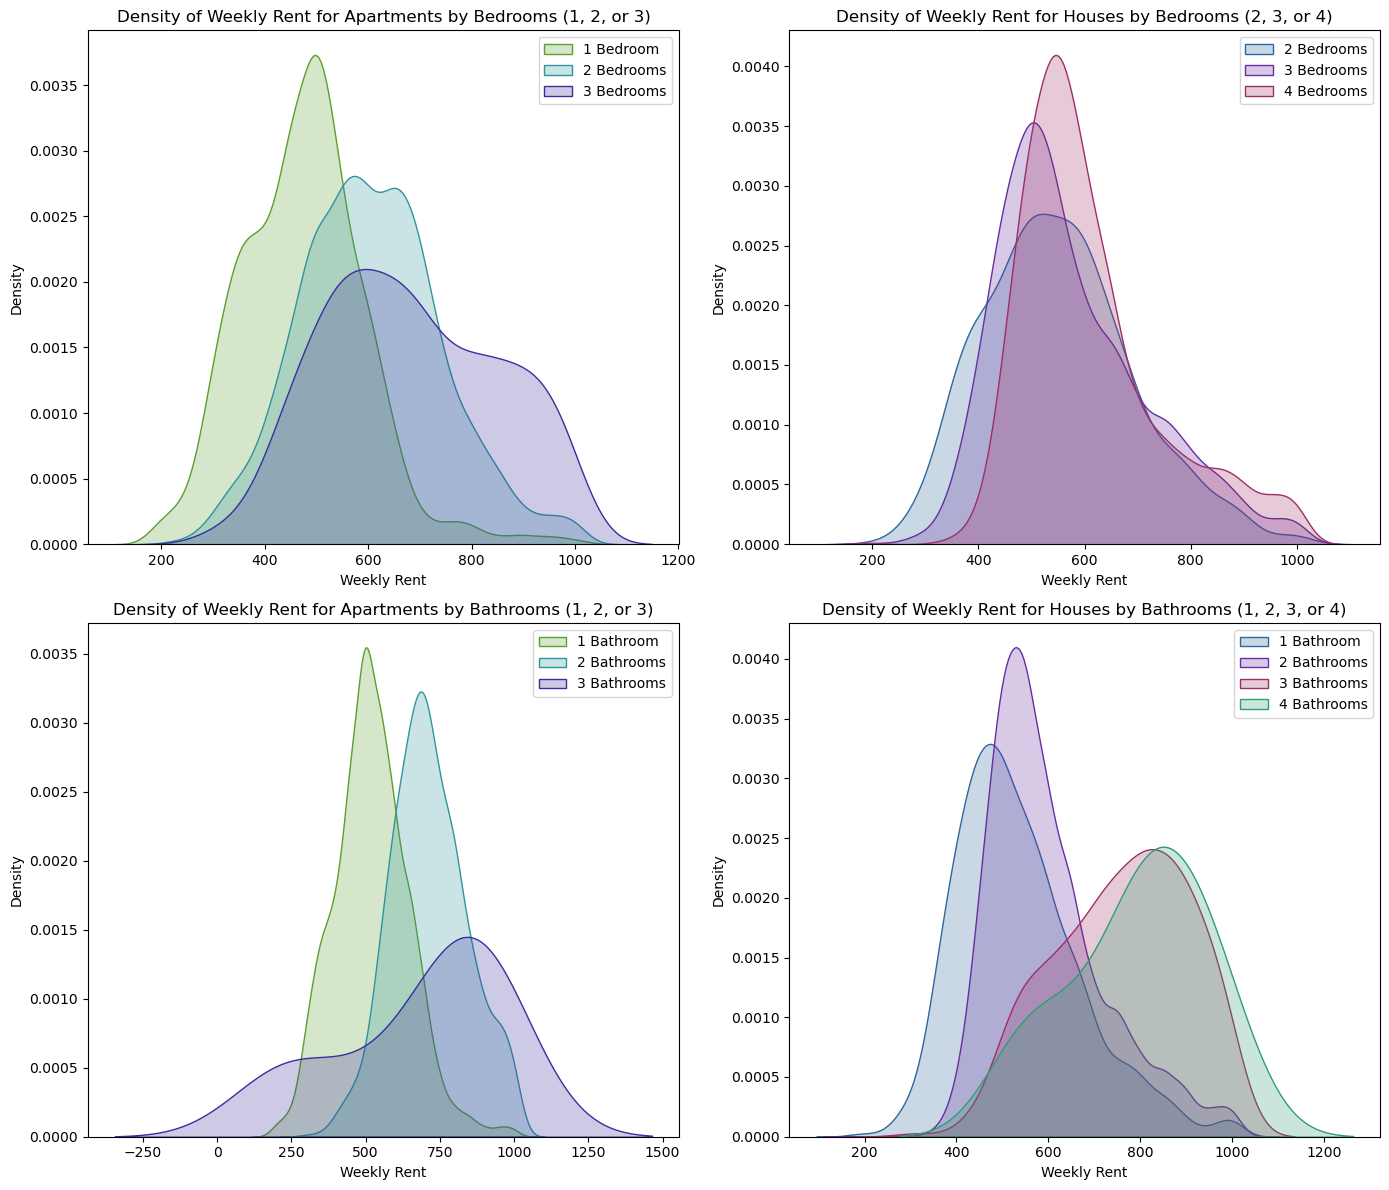

In [80]:
apartment_colors = ['#5B9F2E', '#2E949F', '#3A2E9F']  
house_colors = ['#2E679F', '#662E9F', '#9F2E67', '#2E9F70'] 

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# First row, first subplot: Apartments by Bedrooms
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 1], x='weekly_rent', label='1 Bedroom', fill=True, ax=axes[0, 0], color=apartment_colors[0])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True, ax=axes[0, 0], color=apartment_colors[1])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True, ax=axes[0, 0], color=apartment_colors[2])
axes[0, 0].set_title('Density of Weekly Rent for Apartments by Bedrooms (1, 2, or 3)')
axes[0, 0].set_xlabel('Weekly Rent')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# First row, second subplot: Houses by Bedrooms
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True, ax=axes[0, 1], color=house_colors[0])
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True, ax=axes[0, 1], color=house_colors[1])
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 4], x='weekly_rent', label='4 Bedrooms', fill=True, ax=axes[0, 1], color=house_colors[2])
axes[0, 1].set_title('Density of Weekly Rent for Houses by Bedrooms (2, 3, or 4)')
axes[0, 1].set_xlabel('Weekly Rent')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Second row, first subplot: Apartments by Bathrooms
sns.kdeplot(data=apartment_properties[apartment_properties['num_bath'] == 1], x='weekly_rent', label='1 Bathroom', fill=True, ax=axes[1, 0], color=apartment_colors[0])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bath'] == 2], x='weekly_rent', label='2 Bathrooms', fill=True, ax=axes[1, 0], color=apartment_colors[1])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bath'] == 3], x='weekly_rent', label='3 Bathrooms', fill=True, ax=axes[1, 0], color=apartment_colors[2])
axes[1, 0].set_title('Density of Weekly Rent for Apartments by Bathrooms (1, 2, or 3)')
axes[1, 0].set_xlabel('Weekly Rent')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()

# Second row, second subplot: Houses by Bathrooms
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 1], x='weekly_rent', label='1 Bathroom', fill=True, ax=axes[1, 1], color=house_colors[0])
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 2], x='weekly_rent', label='2 Bathrooms', fill=True, ax=axes[1, 1], color=house_colors[1])
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 3], x='weekly_rent', label='3 Bathrooms', fill=True, ax=axes[1, 1], color=house_colors[2])
sns.kdeplot(data=house_properties[house_properties['num_bath'] == 4], x='weekly_rent', label='4 Bathrooms', fill=True, ax=axes[1, 1], color=house_colors[3])
axes[1, 1].set_title('Density of Weekly Rent for Houses by Bathrooms (1, 2, 3, or 4)')
axes[1, 1].set_xlabel('Weekly Rent')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()

plt.tight_layout()

plt.savefig("../../plots/rental_properties_visualisations/weekly_rent_distribution_rooms.png")
plt.show()


#### Plot the trends in the current most expensive and least expensive suburbs for the three bed houses while offsetting the lines so that they don't overlap - JUST FOR VISUALIZATION PURPOSES

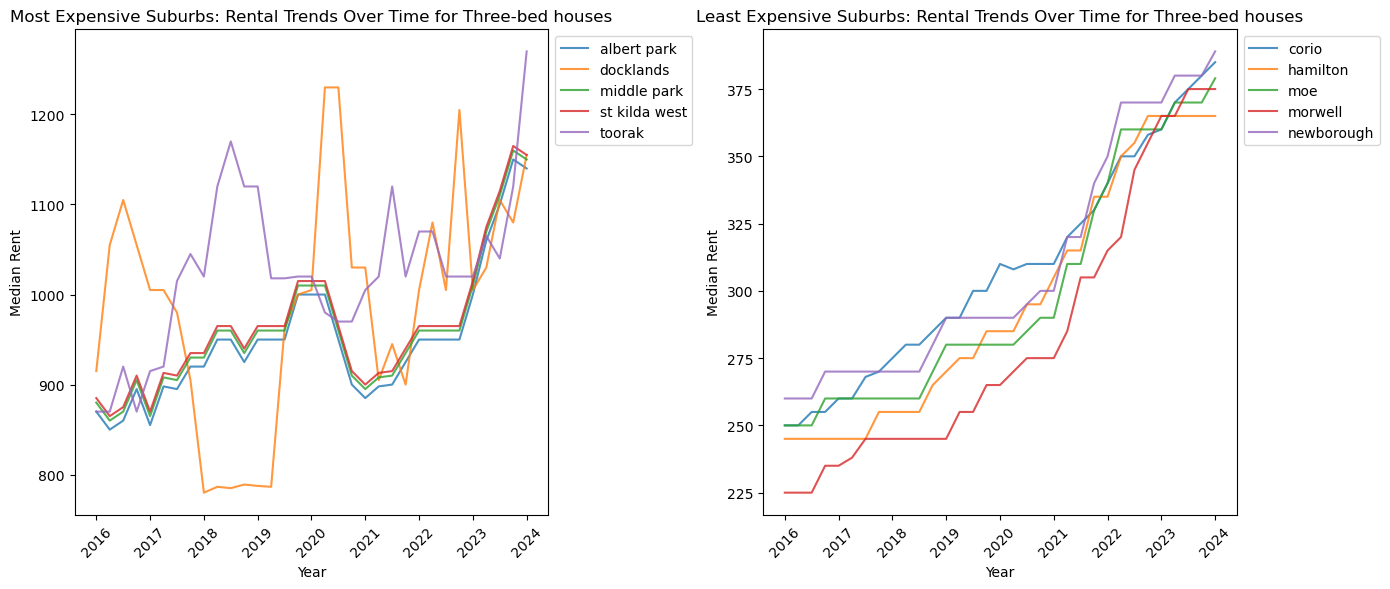

In [78]:
three_bed_house = three_bed_house[three_bed_house['suburb'].str.lower() != 'group total']

# top 5 and bottom 5 suburbs based on the most recent median rent
top_5_expensive = three_bed_house.sort_values(by='mar_2024_median', ascending=False).head(5)
bottom_5_cheap = three_bed_house.sort_values(by='mar_2024_median', ascending=True).head(5)

# Melt the data for plotting trends over time
top_5_melted = top_5_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_5_melted = bottom_5_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

offset_factor = 5  # Offset each line by a small amount to reduce overlap

# Plot for Top 5 Most Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(top_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[0], alpha=0.8, linewidth=1.5)
axes[0].set_title('Most Expensive Suburbs: Rental Trends Over Time for Three-bed houses')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Plot for Bottom 5 Least Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(bottom_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[1], alpha=0.8, linewidth=1.5)
axes[1].set_title('Least Expensive Suburbs: Rental Trends Over Time for Three-bed houses')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  

# format x-ticks to show only the year
for ax in axes:
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] if '_' in label else label for label in xticks_labels]
    ax.set_xticks(ax.get_xticks()[::4]) 
    ax.set_xticklabels(years[::4])

plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/3bhouse_comparison_offset.png")
plt.show()


#### Plot the trends in the current most expensive and least expensive suburbs for the four bed houses while offsetting the lines so that they don't overlap - JUST FOR VISUALIZATION PURPOSES

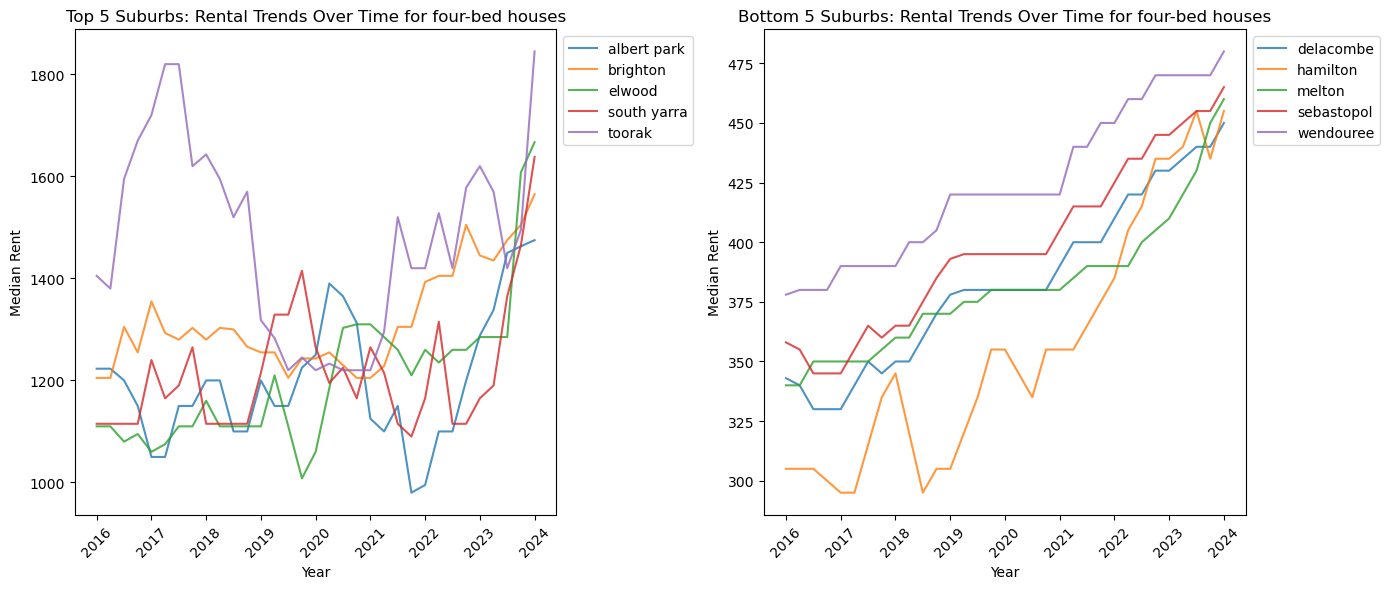

In [76]:
four_bed_house = four_bed_house[four_bed_house['suburb'].str.lower() != 'group total']

# top 5 and bottom 5 suburbs based on the most recent median rent
top_5_expensive = four_bed_house.sort_values(by='mar_2024_median', ascending=False).head(5)
bottom_5_cheap = four_bed_house.sort_values(by='mar_2024_median', ascending=True).head(5)

# Melt the data for plotting trends over time
top_5_melted = top_5_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_5_melted = bottom_5_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

offset_factor = 5  # Offset each line by a small amount to reduce overlap

# Plot for Top 5 Most Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(top_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[0], alpha=0.8, linewidth=1.5)
axes[0].set_title('Top 5 Suburbs: Rental Trends Over Time for four-bed houses')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Plot for Bottom 5 Least Expensive Suburbs with a slight offset for each suburb
for idx, (suburb, data) in enumerate(bottom_5_melted.groupby('suburb')):
    sns.lineplot(data=data, x='quarter', y=data['median_rent'] + idx * offset_factor, label=suburb, ax=axes[1], alpha=0.8, linewidth=1.5)
axes[1].set_title('Bottom 5 Suburbs: Rental Trends Over Time for four-bed houses')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  

# format x-ticks to show only the year
for ax in axes:
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] if '_' in label else label for label in xticks_labels]
    ax.set_xticks(ax.get_xticks()[::4]) 
    ax.set_xticklabels(years[::4])

plt.tight_layout()
plt.savefig("../../plots/rental_properties_visualisations/4bhouse_comparison_offset.png")
plt.show()
